# **First Code**

In [2]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


Cell 1 – Imports & Setup

/tmp/ipykernel_1529/576354233.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Data shape after city filtering: (936, 23)
City selected: sj


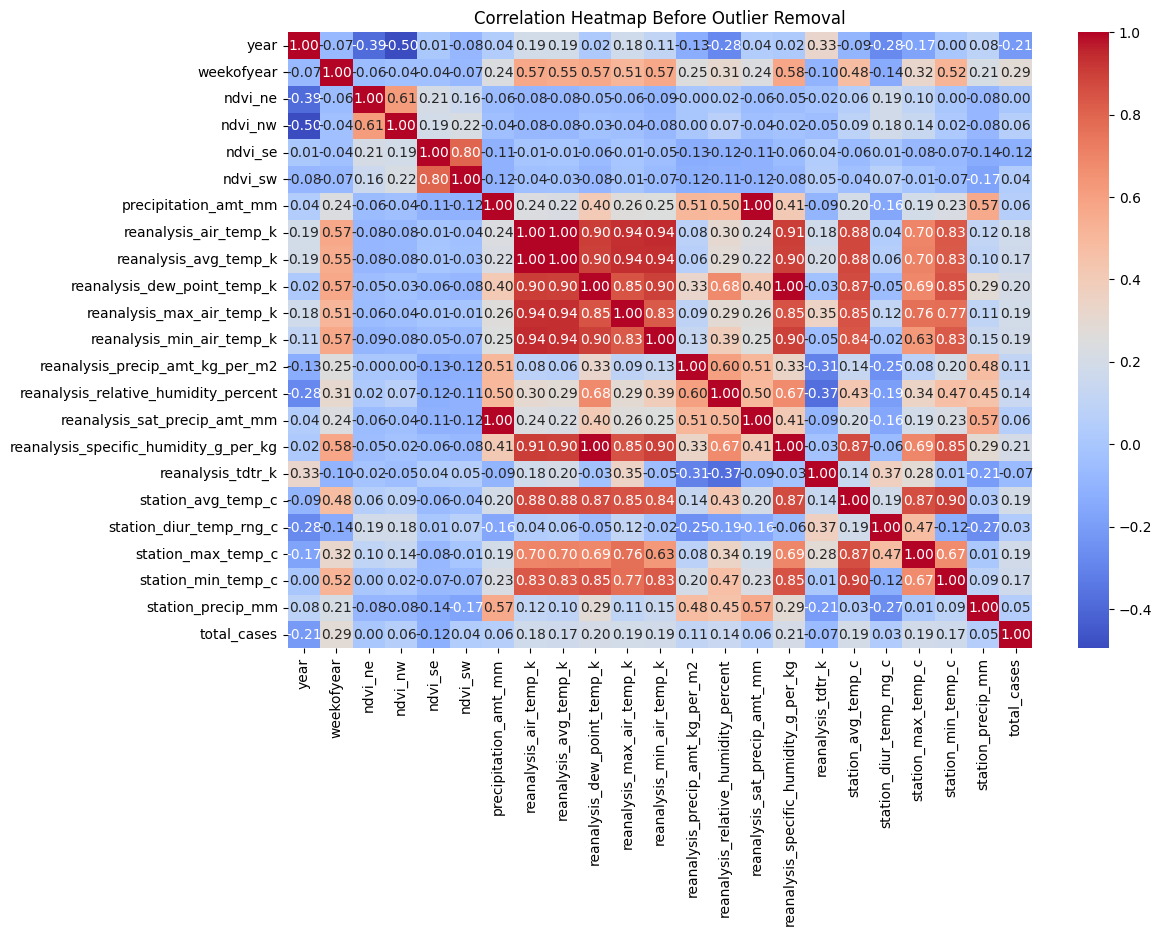

In [37]:
# Cell 1: Imports and city filtering
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

# Load data
df = pd.read_csv('/kaggle/input/america-dengue-data/dengue data 17-07-2025.csv')

# Choose one city only (e.g., 'sj' or 'iq')
selected_city = 'sj'  # 👈 Change to 'iq' for Iquitos
df = df[df['city'] == selected_city].copy()

# Drop unused columns
df.drop(columns=['city', 'week_start_date'], inplace=True)

# Forward fill NaNs
df.fillna(method='ffill', inplace=True)

# --- Visualization ---
print("Data shape after city filtering:", df.shape)
print("City selected:", selected_city)

## Missing data heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
# plt.title("Missing Data Heatmap Before Outlier Removal")
# plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap Before Outlier Removal")
plt.show()


Cell 2: Visualize Outliers Before Removal with Heatmap

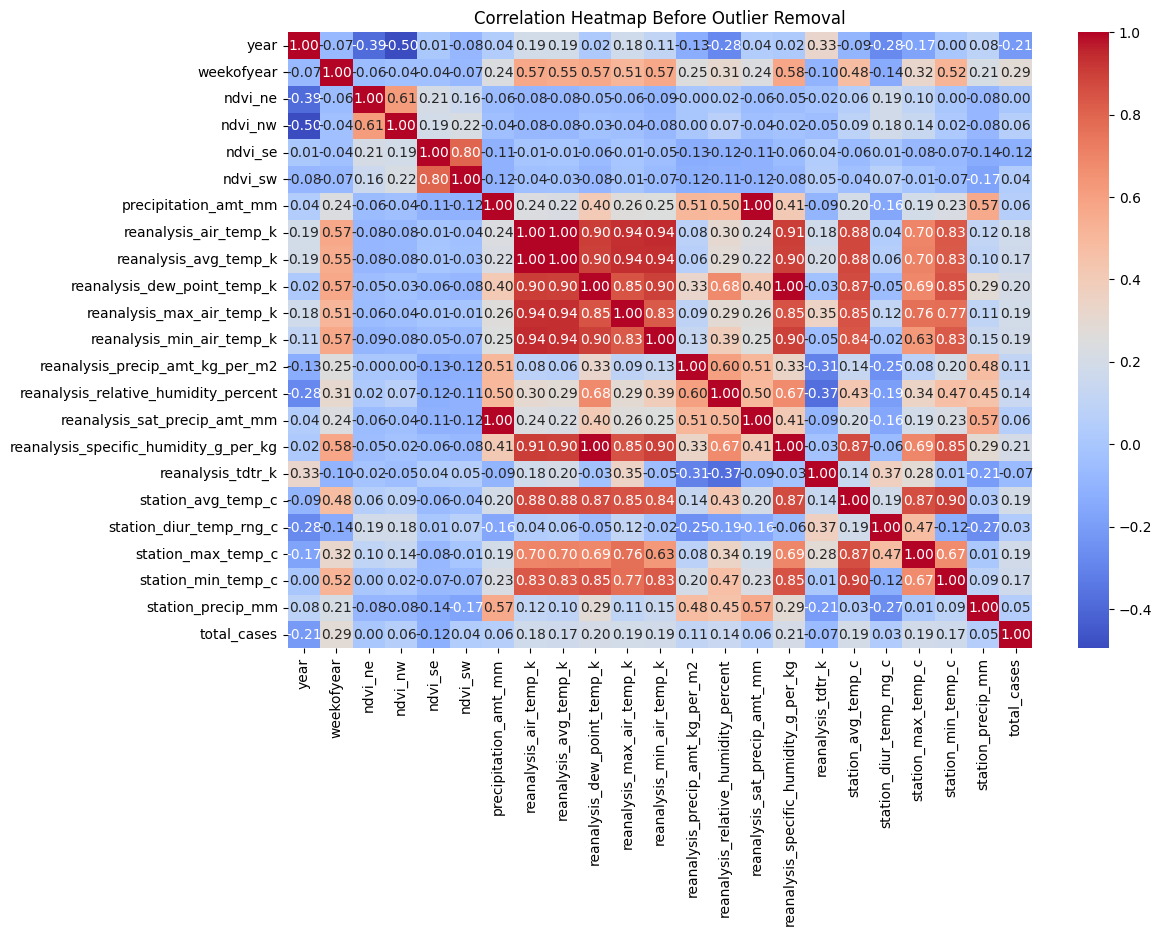

In [39]:
# plt.figure(figsize=(12, 8))
# sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
# plt.title("Missing Data Heatmap Before Outlier Removal")
# plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap Before Outlier Removal")
plt.show()


Cell 3: Outlier Removal Using IQR & Visualize After Removal

Rows before outlier removal: 936
Rows after outlier removal: 644


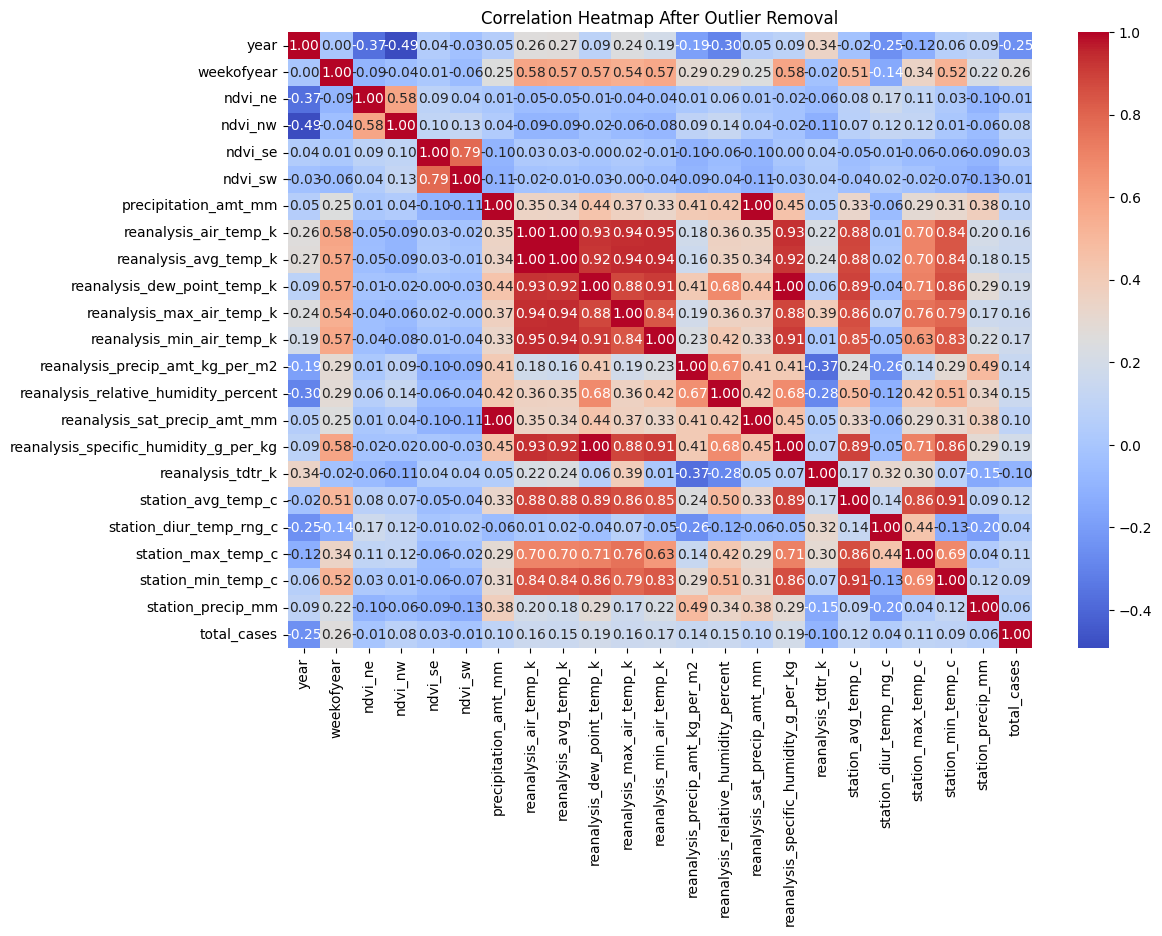

In [41]:
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    condition = ~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
    return df[condition]

df_no_outliers = remove_outliers(df)

print(f"Rows before outlier removal: {len(df)}")
print(f"Rows after outlier removal: {len(df_no_outliers)}")

# plt.figure(figsize=(12, 8))
# sns.heatmap(df_no_outliers.isnull(), cbar=False, yticklabels=False)
# plt.title("Missing Data Heatmap After Outlier Removal")
# plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df_no_outliers.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap After Outlier Removal")
plt.show()


Cell 4: Lag Features Creation & Target/Feature Separation

In [42]:
df = df_no_outliers.copy()

for lag in [1, 2, 3]:
    df[f'total_cases_lag{lag}'] = df['total_cases'].shift(lag)

df.dropna(inplace=True)

target_col = 'total_cases'
features = df.drop(columns=[target_col])


Cell 5: Remove Low Variance & High Correlation Features

In [43]:
def drop_low_variance(df, thresh=0.01):
    sel = VarianceThreshold(thresh)
    return df[df.columns[sel.fit(df).get_support()]]

def drop_high_corr(df, thresh=0.9):
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > thresh)]
    return df.drop(columns=to_drop)

features = drop_low_variance(features)
features = drop_high_corr(features)

features


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,year,weekofyear,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_precip_mm,total_cases_lag1,total_cases_lag2,total_cases_lag3
3,1990,21,15.36,298.987143,13.90,80.337143,2.428571,27.471429,6.771429,33.3,4.0,4.0,5.0,4.0
5,1990,23,9.58,299.630000,26.49,79.891429,2.100000,28.114286,6.942857,34.4,39.1,3.0,4.0,5.0
6,1990,24,3.48,299.207143,38.60,82.000000,2.042857,27.414286,6.771429,32.2,29.7,2.0,3.0,4.0
8,1990,26,19.32,299.578571,37.51,82.768571,1.885714,28.328571,7.385714,33.9,21.1,4.0,2.0,3.0
9,1990,27,14.41,300.154286,28.40,81.281429,2.014286,28.328571,6.514286,33.9,1.1,10.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,2008,9,0.00,297.765714,6.46,72.660000,2.285714,24.742857,5.500000,27.8,12.9,8.0,6.0,15.0
928,2008,10,0.00,297.878571,6.50,74.681429,2.614286,25.114286,6.114286,29.4,13.0,5.0,8.0,6.0
931,2008,13,27.19,296.958571,7.55,74.247143,2.885714,25.042857,5.785714,30.0,1.8,1.0,5.0,8.0
932,2008,14,3.82,298.081429,3.67,74.600000,2.714286,26.242857,6.814286,30.6,0.5,4.0,1.0,5.0


Cell 6: Scale Features and Target

In [44]:
feat_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_feat = feat_scaler.fit_transform(features)
y = df[target_col].values.reshape(-1, 1)
y_scaled = target_scaler.fit_transform(y)

print("Feature shape:", X_feat.shape)
print("Target shape:", y_scaled.shape)


Feature shape: (641, 14)
Target shape: (641, 1)


Cell 7: Prepare Time-Series Windows & Train-Val-Test Split

In [56]:
# window_size = 10
# X, y = [], []

# for i in range(len(X_feat) - window_size):
#     X.append(X_feat[i:i+window_size])
#     y.append(y_scaled[i+window_size])

# X = np.array(X)
# y = np.array(y)

# total_len = len(X)
# train_len = int(0.7 * total_len)
# val_len = int(0.15 * total_len)

# X_train, y_train = X[:train_len], y[:train_len]
# X_val, y_val = X[train_len:train_len + val_len], y[train_len:train_len + val_len]
# X_test, y_test = X[train_len + val_len:], y[train_len + val_len:]

# print(f"Train size: {X_train.shape[0]}, Val size: {X_val.shape[0]}, Test size: {X_test.shape[0]}")

total_len = len(X)
train_len = int(0.8 * total_len)

X_train, y_train = X[:train_len], y[:train_len]
X_test, y_test = X[train_len:], y[train_len:]


Cell 8: Define Model & Objective Function for Optuna

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import optuna

def create_model(input_shape, trial):
    model = Sequential()
    n_layers = trial.suggest_int('n_layers', 1, 4)
    for i in range(n_layers):
        units = trial.suggest_int(f'units_l{i}', 64, 256, step=32)
        return_seq = i < n_layers - 1
        if i == 0:
            model.add(LSTM(units, return_sequences=return_seq, input_shape=input_shape))
        else:
            model.add(LSTM(units, return_sequences=return_seq))
        model.add(Dropout(trial.suggest_float(f'dropout_l{i}', 0.1, 0.5)))
    model.add(Dense(1))
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'nadam', 'rmsprop'])
    model.compile(optimizer=optimizer, loss='mse')
    return model

def objective(trial):
    model = create_model((window_size, X.shape[2]), trial)
    # model.to("GPU")
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=120,
        batch_size=trial.suggest_categorical('batch_size', [16, 32, 64,128]),
        callbacks=[early_stop],
        verbose=0
    )
    pred_val = model.predict(X_val)
    val_mse = mean_squared_error(y_val, pred_val)
    return val_mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_trial.params)


[I 2025-07-25 10:06:58,000] A new study created in memory with name: no-name-072ffe8c-e048-4f68-bb68-26a4ea66aa76
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-07-25 10:07:04,072] Trial 0 finished with value: 0.00586534722764313 and parameters: {'n_layers': 1, 'units_l0': 192, 'dropout_l0': 0.22328423319107366, 'optimizer': 'adam', 'batch_size': 128}. Best is trial 0 with value: 0.00586534722764313.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


[I 2025-07-25 10:07:07,514] Trial 1 finished with value: 0.007710695930220894 and parameters: {'n_layers': 1, 'units_l0': 256, 'dropout_l0': 0.3302188703408676, 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 0 with value: 0.00586534722764313.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step


[I 2025-07-25 10:07:25,277] Trial 2 finished with value: 0.0049769577928261265 and parameters: {'n_layers': 4, 'units_l0': 224, 'dropout_l0': 0.36071311876935785, 'units_l1': 256, 'dropout_l1': 0.3045928954354532, 'units_l2': 192, 'dropout_l2': 0.2561190771085436, 'units_l3': 64, 'dropout_l3': 0.17681072503273507, 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 2 with value: 0.0049769577928261265.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


[I 2025-07-25 10:07:39,031] Trial 3 finished with value: 0.004779954887924704 and parameters: {'n_layers': 3, 'units_l0': 96, 'dropout_l0': 0.3764514628209409, 'units_l1': 192, 'dropout_l1': 0.4136495809478592, 'units_l2': 64, 'dropout_l2': 0.10152845631637174, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 3 with value: 0.004779954887924704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


[I 2025-07-25 10:07:50,551] Trial 4 finished with value: 0.0049346889060131564 and parameters: {'n_layers': 3, 'units_l0': 128, 'dropout_l0': 0.19841377198298227, 'units_l1': 256, 'dropout_l1': 0.30204825821570636, 'units_l2': 256, 'dropout_l2': 0.3363022683871187, 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 3 with value: 0.004779954887924704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[I 2025-07-25 10:07:56,713] Trial 5 finished with value: 0.0056295143274890875 and parameters: {'n_layers': 1, 'units_l0': 256, 'dropout_l0': 0.402388894618787, 'optimizer': 'nadam', 'batch_size': 32}. Best is trial 3 with value: 0.004779954887924704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


[I 2025-07-25 10:08:06,441] Trial 6 finished with value: 0.005094397024439611 and parameters: {'n_layers': 2, 'units_l0': 64, 'dropout_l0': 0.33831451198457724, 'units_l1': 96, 'dropout_l1': 0.47513364875614983, 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 3 with value: 0.004779954887924704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step  


[I 2025-07-25 10:08:23,222] Trial 7 finished with value: 0.005269024872149284 and parameters: {'n_layers': 4, 'units_l0': 128, 'dropout_l0': 0.2658818783275446, 'units_l1': 96, 'dropout_l1': 0.400747566693738, 'units_l2': 160, 'dropout_l2': 0.4087603275024524, 'units_l3': 160, 'dropout_l3': 0.4166580094559611, 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 3 with value: 0.004779954887924704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step


[I 2025-07-25 10:08:39,093] Trial 8 finished with value: 0.005961640142079493 and parameters: {'n_layers': 4, 'units_l0': 96, 'dropout_l0': 0.3631353667723939, 'units_l1': 96, 'dropout_l1': 0.11446974566981996, 'units_l2': 160, 'dropout_l2': 0.4689706688738474, 'units_l3': 256, 'dropout_l3': 0.39382918574000414, 'optimizer': 'nadam', 'batch_size': 64}. Best is trial 3 with value: 0.004779954887924704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


[I 2025-07-25 10:08:50,589] Trial 9 finished with value: 0.006127708389386422 and parameters: {'n_layers': 3, 'units_l0': 96, 'dropout_l0': 0.3489824492259769, 'units_l1': 64, 'dropout_l1': 0.40351985267164603, 'units_l2': 64, 'dropout_l2': 0.13472487572944059, 'optimizer': 'adam', 'batch_size': 128}. Best is trial 3 with value: 0.004779954887924704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


[I 2025-07-25 10:09:01,658] Trial 10 finished with value: 0.005235190352022505 and parameters: {'n_layers': 2, 'units_l0': 160, 'dropout_l0': 0.11294478285735693, 'units_l1': 192, 'dropout_l1': 0.16020134817057635, 'optimizer': 'nadam', 'batch_size': 16}. Best is trial 3 with value: 0.004779954887924704.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


[I 2025-07-25 10:09:14,971] Trial 11 finished with value: 0.004675201391962435 and parameters: {'n_layers': 3, 'units_l0': 128, 'dropout_l0': 0.4887713849089859, 'units_l1': 256, 'dropout_l1': 0.2697125170942002, 'units_l2': 64, 'dropout_l2': 0.29648412714376104, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 11 with value: 0.004675201391962435.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


[I 2025-07-25 10:09:29,862] Trial 12 finished with value: 0.004701058692104223 and parameters: {'n_layers': 3, 'units_l0': 64, 'dropout_l0': 0.4798078163590451, 'units_l1': 192, 'dropout_l1': 0.21528041414302237, 'units_l2': 64, 'dropout_l2': 0.10703930748180399, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 11 with value: 0.004675201391962435.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


[I 2025-07-25 10:09:49,553] Trial 13 finished with value: 0.005023857732015819 and parameters: {'n_layers': 3, 'units_l0': 64, 'dropout_l0': 0.496649161265553, 'units_l1': 192, 'dropout_l1': 0.21371402977116108, 'units_l2': 96, 'dropout_l2': 0.22642314336895503, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 11 with value: 0.004675201391962435.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


[I 2025-07-25 10:09:59,650] Trial 14 finished with value: 0.004912273382180072 and parameters: {'n_layers': 2, 'units_l0': 160, 'dropout_l0': 0.49726404148656633, 'units_l1': 224, 'dropout_l1': 0.21554681513552587, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 11 with value: 0.004675201391962435.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


[I 2025-07-25 10:10:13,073] Trial 15 finished with value: 0.005340658182514541 and parameters: {'n_layers': 3, 'units_l0': 128, 'dropout_l0': 0.4358807764407848, 'units_l1': 160, 'dropout_l1': 0.23839640025469264, 'units_l2': 96, 'dropout_l2': 0.19121561162999604, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 11 with value: 0.004675201391962435.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


[I 2025-07-25 10:10:25,305] Trial 16 finished with value: 0.004897189536467655 and parameters: {'n_layers': 2, 'units_l0': 64, 'dropout_l0': 0.4440306421153748, 'units_l1': 160, 'dropout_l1': 0.2893963260806807, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 11 with value: 0.004675201391962435.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step


[I 2025-07-25 10:10:43,699] Trial 17 finished with value: 0.004939142234692685 and parameters: {'n_layers': 4, 'units_l0': 192, 'dropout_l0': 0.4518173004320237, 'units_l1': 224, 'dropout_l1': 0.2632240897227762, 'units_l2': 96, 'dropout_l2': 0.3243038637712042, 'units_l3': 64, 'dropout_l3': 0.10172003573973229, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 11 with value: 0.004675201391962435.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


[I 2025-07-25 10:11:01,681] Trial 18 finished with value: 0.004997470331212425 and parameters: {'n_layers': 3, 'units_l0': 96, 'dropout_l0': 0.41807650239017496, 'units_l1': 224, 'dropout_l1': 0.33836395521079726, 'units_l2': 128, 'dropout_l2': 0.3881348553625015, 'optimizer': 'nadam', 'batch_size': 16}. Best is trial 11 with value: 0.004675201391962435.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


[I 2025-07-25 10:11:14,375] Trial 19 finished with value: 0.004970203157291751 and parameters: {'n_layers': 2, 'units_l0': 128, 'dropout_l0': 0.4711039874038335, 'units_l1': 256, 'dropout_l1': 0.1625014928337498, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 11 with value: 0.004675201391962435.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step


[I 2025-07-25 10:11:28,937] Trial 20 finished with value: 0.004701068651860042 and parameters: {'n_layers': 4, 'units_l0': 192, 'dropout_l0': 0.27864969997491856, 'units_l1': 160, 'dropout_l1': 0.18520900610864677, 'units_l2': 64, 'dropout_l2': 0.1715978495103952, 'units_l3': 256, 'dropout_l3': 0.2582545007208022, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 11 with value: 0.004675201391962435.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step


[I 2025-07-25 10:11:41,529] Trial 21 finished with value: 0.005426747438452209 and parameters: {'n_layers': 4, 'units_l0': 192, 'dropout_l0': 0.28612040815272566, 'units_l1': 160, 'dropout_l1': 0.18346880619154515, 'units_l2': 64, 'dropout_l2': 0.15009279896216998, 'units_l3': 256, 'dropout_l3': 0.252963473577579, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 11 with value: 0.004675201391962435.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step


[I 2025-07-25 10:11:57,558] Trial 22 finished with value: 0.0048521030219768595 and parameters: {'n_layers': 4, 'units_l0': 224, 'dropout_l0': 0.236582022988777, 'units_l1': 128, 'dropout_l1': 0.1057983297724502, 'units_l2': 64, 'dropout_l2': 0.1866327297733781, 'units_l3': 192, 'dropout_l3': 0.3004851166815005, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 11 with value: 0.004675201391962435.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


[I 2025-07-25 10:12:10,372] Trial 23 finished with value: 0.005156321779815333 and parameters: {'n_layers': 3, 'units_l0': 160, 'dropout_l0': 0.3077825905330535, 'units_l1': 128, 'dropout_l1': 0.25220776121452315, 'units_l2': 96, 'dropout_l2': 0.2681956185333849, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 11 with value: 0.004675201391962435.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


[I 2025-07-25 10:12:22,447] Trial 24 finished with value: 0.005330403021572156 and parameters: {'n_layers': 3, 'units_l0': 224, 'dropout_l0': 0.1634460536790788, 'units_l1': 192, 'dropout_l1': 0.1887189254408538, 'units_l2': 128, 'dropout_l2': 0.1055154401229575, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 11 with value: 0.004675201391962435.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step


[I 2025-07-25 10:12:42,017] Trial 25 finished with value: 0.004695843320169228 and parameters: {'n_layers': 4, 'units_l0': 160, 'dropout_l0': 0.3971795789606327, 'units_l1': 128, 'dropout_l1': 0.3490365844731518, 'units_l2': 64, 'dropout_l2': 0.18152357190808635, 'units_l3': 192, 'dropout_l3': 0.31109615872708, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 11 with value: 0.004675201391962435.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


[I 2025-07-25 10:12:57,641] Trial 26 finished with value: 0.004509644353717714 and parameters: {'n_layers': 3, 'units_l0': 160, 'dropout_l0': 0.3959775021648761, 'units_l1': 128, 'dropout_l1': 0.3525583903690704, 'units_l2': 128, 'dropout_l2': 0.22034902585351543, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step


[I 2025-07-25 10:13:11,711] Trial 27 finished with value: 0.0051272358789771644 and parameters: {'n_layers': 4, 'units_l0': 160, 'dropout_l0': 0.39935773760806065, 'units_l1': 128, 'dropout_l1': 0.3542767692159747, 'units_l2': 224, 'dropout_l2': 0.22972595024939882, 'units_l3': 160, 'dropout_l3': 0.4795971254143281, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


[I 2025-07-25 10:13:26,213] Trial 28 finished with value: 0.005079785677062208 and parameters: {'n_layers': 3, 'units_l0': 128, 'dropout_l0': 0.3980858700219234, 'units_l1': 64, 'dropout_l1': 0.3491501130986143, 'units_l2': 128, 'dropout_l2': 0.2887646227660813, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


[I 2025-07-25 10:13:37,073] Trial 29 finished with value: 0.005805488607336526 and parameters: {'n_layers': 2, 'units_l0': 192, 'dropout_l0': 0.4607042323010966, 'units_l1': 128, 'dropout_l1': 0.3701213007029014, 'optimizer': 'nadam', 'batch_size': 128}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step


[I 2025-07-25 10:13:55,068] Trial 30 finished with value: 0.004885966615619539 and parameters: {'n_layers': 4, 'units_l0': 160, 'dropout_l0': 0.4166458923720169, 'units_l1': 96, 'dropout_l1': 0.45092002096040606, 'units_l2': 160, 'dropout_l2': 0.2414085123352938, 'units_l3': 192, 'dropout_l3': 0.33354999672017666, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


[I 2025-07-25 10:14:11,468] Trial 31 finished with value: 0.004818780680757727 and parameters: {'n_layers': 3, 'units_l0': 128, 'dropout_l0': 0.4751449842226616, 'units_l1': 128, 'dropout_l1': 0.3097085435197574, 'units_l2': 96, 'dropout_l2': 0.20269251236254707, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


[I 2025-07-25 10:14:24,012] Trial 32 finished with value: 0.0048961878920308725 and parameters: {'n_layers': 3, 'units_l0': 160, 'dropout_l0': 0.4782418738765927, 'units_l1': 224, 'dropout_l1': 0.274874552479657, 'units_l2': 64, 'dropout_l2': 0.14124043400202185, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


[I 2025-07-25 10:14:37,845] Trial 33 finished with value: 0.0046747696394267456 and parameters: {'n_layers': 3, 'units_l0': 96, 'dropout_l0': 0.3178203358305919, 'units_l1': 256, 'dropout_l1': 0.32030505599749537, 'units_l2': 96, 'dropout_l2': 0.3117482686539919, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[I 2025-07-25 10:14:44,523] Trial 34 finished with value: 0.005465624109291656 and parameters: {'n_layers': 1, 'units_l0': 96, 'dropout_l0': 0.38399159207851424, 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


[I 2025-07-25 10:15:01,102] Trial 35 finished with value: 0.004846035972284978 and parameters: {'n_layers': 3, 'units_l0': 96, 'dropout_l0': 0.31769639363568014, 'units_l1': 256, 'dropout_l1': 0.3209489734436968, 'units_l2': 128, 'dropout_l2': 0.3451056270566202, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step


[I 2025-07-25 10:15:26,249] Trial 36 finished with value: 0.004599498248110385 and parameters: {'n_layers': 4, 'units_l0': 128, 'dropout_l0': 0.36766877153425503, 'units_l1': 256, 'dropout_l1': 0.3751429824542596, 'units_l2': 96, 'dropout_l2': 0.2797152411727396, 'units_l3': 128, 'dropout_l3': 0.18068336706908422, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


[I 2025-07-25 10:15:40,436] Trial 37 finished with value: 0.004836772766449694 and parameters: {'n_layers': 2, 'units_l0': 128, 'dropout_l0': 0.32425978274353295, 'units_l1': 256, 'dropout_l1': 0.4292914387786771, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


[I 2025-07-25 10:15:56,194] Trial 38 finished with value: 0.004848676603683676 and parameters: {'n_layers': 3, 'units_l0': 128, 'dropout_l0': 0.247166435055637, 'units_l1': 256, 'dropout_l1': 0.3792349891298725, 'units_l2': 96, 'dropout_l2': 0.2950268160008896, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


[I 2025-07-25 10:16:05,228] Trial 39 finished with value: 0.0054081759522977306 and parameters: {'n_layers': 1, 'units_l0': 96, 'dropout_l0': 0.3685735762155425, 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


[I 2025-07-25 10:16:22,401] Trial 40 finished with value: 0.005411525252563973 and parameters: {'n_layers': 3, 'units_l0': 96, 'dropout_l0': 0.3471545420175023, 'units_l1': 224, 'dropout_l1': 0.3227519553633864, 'units_l2': 128, 'dropout_l2': 0.3627703856728898, 'optimizer': 'nadam', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step


[I 2025-07-25 10:16:36,893] Trial 41 finished with value: 0.004647251231920831 and parameters: {'n_layers': 4, 'units_l0': 160, 'dropout_l0': 0.379090685858808, 'units_l1': 256, 'dropout_l1': 0.38072348504406267, 'units_l2': 96, 'dropout_l2': 0.31341645208442304, 'units_l3': 128, 'dropout_l3': 0.1848882465428209, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step


[I 2025-07-25 10:16:59,652] Trial 42 finished with value: 0.00469311841422784 and parameters: {'n_layers': 4, 'units_l0': 128, 'dropout_l0': 0.3752491011716486, 'units_l1': 256, 'dropout_l1': 0.38299456678479205, 'units_l2': 96, 'dropout_l2': 0.2985478576023248, 'units_l3': 128, 'dropout_l3': 0.16453661373310488, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step


[I 2025-07-25 10:17:14,967] Trial 43 finished with value: 0.005084020157638948 and parameters: {'n_layers': 4, 'units_l0': 160, 'dropout_l0': 0.33960771646148885, 'units_l1': 256, 'dropout_l1': 0.4329540896579926, 'units_l2': 128, 'dropout_l2': 0.25906198707873723, 'units_l3': 96, 'dropout_l3': 0.19738879122672098, 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step


[I 2025-07-25 10:17:35,824] Trial 44 finished with value: 0.004666836954042551 and parameters: {'n_layers': 4, 'units_l0': 128, 'dropout_l0': 0.4209506299693867, 'units_l1': 224, 'dropout_l1': 0.29402444004613587, 'units_l2': 96, 'dropout_l2': 0.3183682523317146, 'units_l3': 128, 'dropout_l3': 0.1102317289572708, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step


[I 2025-07-25 10:17:49,924] Trial 45 finished with value: 0.005064030841161095 and parameters: {'n_layers': 4, 'units_l0': 192, 'dropout_l0': 0.42944534554405345, 'units_l1': 224, 'dropout_l1': 0.4006943932841973, 'units_l2': 96, 'dropout_l2': 0.3202180911962206, 'units_l3': 128, 'dropout_l3': 0.11150510760987514, 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step


[I 2025-07-25 10:18:06,435] Trial 46 finished with value: 0.004695977033241387 and parameters: {'n_layers': 4, 'units_l0': 128, 'dropout_l0': 0.3537674421711902, 'units_l1': 256, 'dropout_l1': 0.28750363601266044, 'units_l2': 128, 'dropout_l2': 0.2627363303694679, 'units_l3': 128, 'dropout_l3': 0.15847782567819615, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step


[I 2025-07-25 10:18:25,493] Trial 47 finished with value: 0.004830854792202623 and parameters: {'n_layers': 4, 'units_l0': 160, 'dropout_l0': 0.2962353812143272, 'units_l1': 224, 'dropout_l1': 0.36920094448484025, 'units_l2': 192, 'dropout_l2': 0.36762457270899845, 'units_l3': 96, 'dropout_l3': 0.22435999725354164, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step


[I 2025-07-25 10:18:42,189] Trial 48 finished with value: 0.0055254582819852325 and parameters: {'n_layers': 4, 'units_l0': 96, 'dropout_l0': 0.38522800737532725, 'units_l1': 256, 'dropout_l1': 0.46563839916903527, 'units_l2': 96, 'dropout_l2': 0.41567603169848394, 'units_l3': 96, 'dropout_l3': 0.13331237139308608, 'optimizer': 'nadam', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step


[I 2025-07-25 10:18:57,038] Trial 49 finished with value: 0.00511115055295669 and parameters: {'n_layers': 4, 'units_l0': 128, 'dropout_l0': 0.33156381911910143, 'units_l1': 224, 'dropout_l1': 0.3320811965593437, 'units_l2': 160, 'dropout_l2': 0.3330953571319279, 'units_l3': 128, 'dropout_l3': 0.21276877226791788, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 26 with value: 0.004509644353717714.


Best parameters: {'n_layers': 3, 'units_l0': 160, 'dropout_l0': 0.3959775021648761, 'units_l1': 128, 'dropout_l1': 0.3525583903690704, 'units_l2': 128, 'dropout_l2': 0.22034902585351543, 'optimizer': 'rmsprop', 'batch_size': 16}


Cell 9: Build Best Model & Train

In [58]:
p = study.best_trial.params

model = Sequential()
for i in range(p['n_layers']):
    units = p[f'units_l{i}']
    return_seq = i < p['n_layers'] - 1
    if i == 0:
        model.add(LSTM(units, return_sequences=return_seq, input_shape=(window_size, X.shape[2])))
    else:
        model.add(LSTM(units, return_sequences=return_seq))
    model.add(Dropout(p[f'dropout_l{i}']))
model.add(Dense(1))
model.compile(optimizer=p['optimizer'], loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=45, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=p['batch_size'],
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 - 3s - 106ms/step - loss: 0.0524 - val_loss: 0.0127
Epoch 2/200
32/32 - 0s - 8ms/step - loss: 0.0367 - val_loss: 0.0109
Epoch 3/200
32/32 - 0s - 8ms/step - loss: 0.0312 - val_loss: 0.0148
Epoch 4/200
32/32 - 0s - 8ms/step - loss: 0.0306 - val_loss: 0.0088
Epoch 5/200
32/32 - 0s - 8ms/step - loss: 0.0308 - val_loss: 0.0091
Epoch 6/200
32/32 - 0s - 8ms/step - loss: 0.0266 - val_loss: 0.0265
Epoch 7/200
32/32 - 0s - 8ms/step - loss: 0.0274 - val_loss: 0.0076
Epoch 8/200
32/32 - 0s - 8ms/step - loss: 0.0237 - val_loss: 0.0294
Epoch 9/200
32/32 - 0s - 8ms/step - loss: 0.0232 - val_loss: 0.0066
Epoch 10/200
32/32 - 0s - 8ms/step - loss: 0.0248 - val_loss: 0.0171
Epoch 11/200
32/32 - 0s - 8ms/step - loss: 0.0225 - val_loss: 0.0072
Epoch 12/200
32/32 - 0s - 8ms/step - loss: 0.0199 - val_loss: 0.0058
Epoch 13/200
32/32 - 0s - 8ms/step - loss: 0.0201 - val_loss: 0.0073
Epoch 14/200
32/32 - 0s - 8ms/step - loss: 0.0191 - val_loss: 0.0063
Epoch 15/200
32/32 - 0s - 8ms/step - loss: 0.0203 - v

Cell 10: Evaluate Model & Plot Results

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Test MSE: 119.03
Test RMSE: 10.91
Test MAE: 7.42


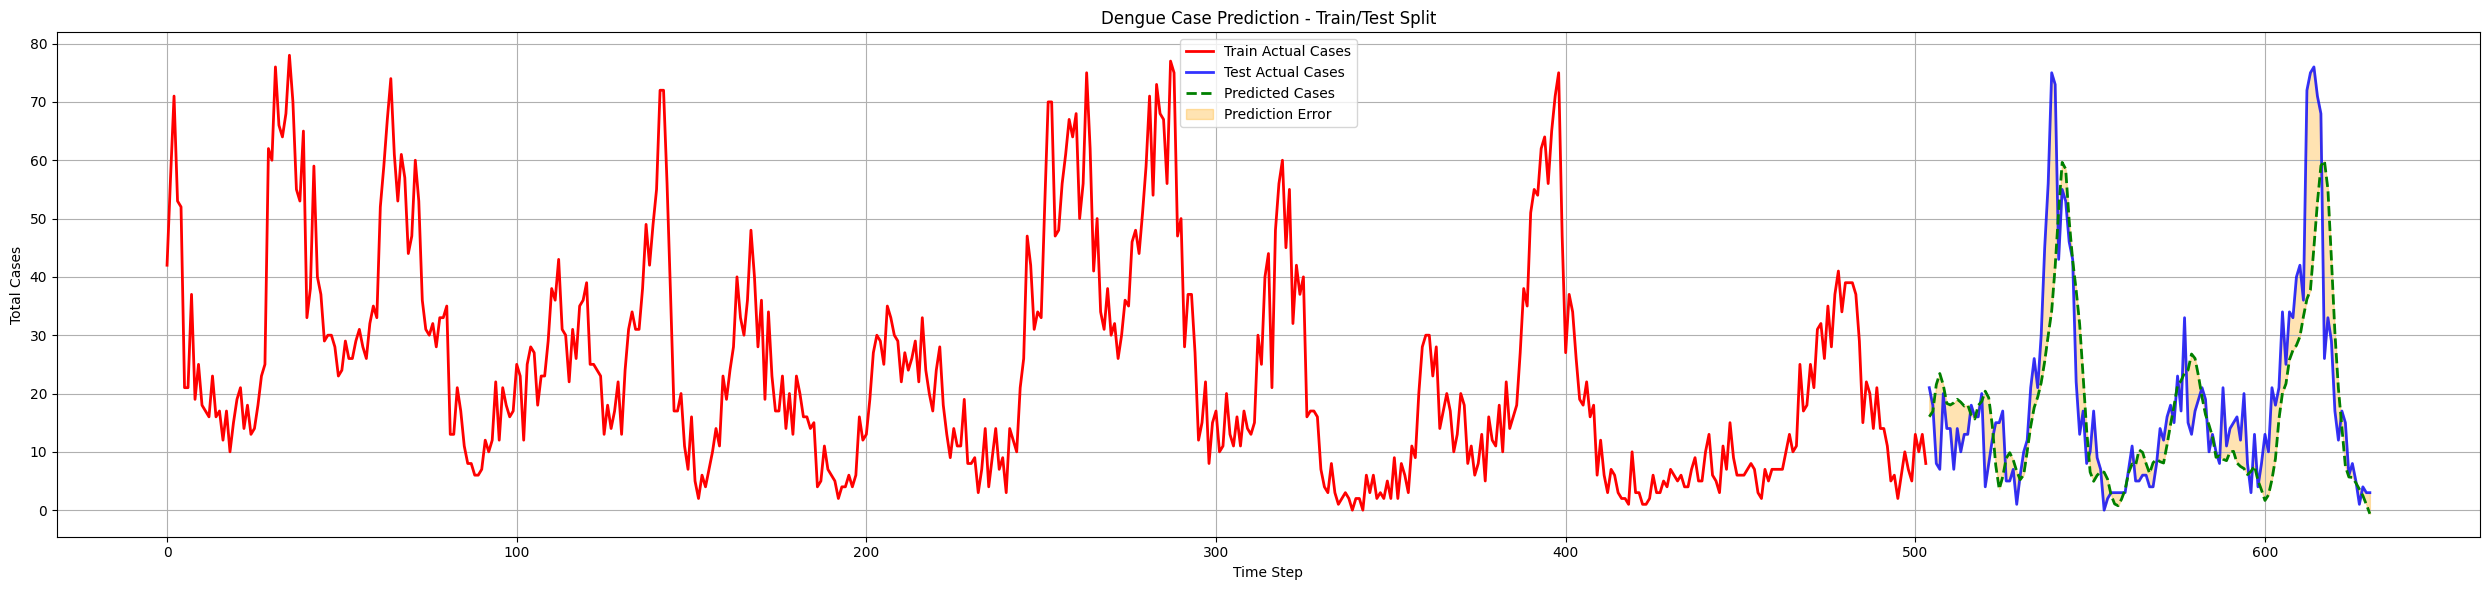

In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Predict
pred_scaled = model.predict(X_test)
pred = target_scaler.inverse_transform(pred_scaled)
actual_test = target_scaler.inverse_transform(y_test)
all_actual = target_scaler.inverse_transform(y)  # Full target series

# Evaluation
mse = mean_squared_error(actual_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_test, pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

# Indices
test_start_idx = len(all_actual) - len(actual_test)
time_axis = np.arange(len(all_actual))

# Plotting
plt.figure(figsize=(25, 6))

# 🔴 Red: Train actual data
plt.plot(time_axis[:test_start_idx], all_actual[:test_start_idx],
         label='Train Actual Cases', color='red', linewidth=2)

# 🔵 Blue: Test actual data
plt.plot(time_axis[test_start_idx:], all_actual[test_start_idx:],
         label='Test Actual Cases', color='blue', linewidth=2, alpha=0.8)

# 🟢 Green: Model predictions
plt.plot(time_axis[test_start_idx:], pred,
         label='Predicted Cases', color='green', linewidth=2, linestyle='--')

# Optional: Error shading (optional for visual)
plt.fill_between(time_axis[test_start_idx:], 
                 all_actual[test_start_idx:].flatten(), 
                 pred.flatten(),
                 color='orange', alpha=0.3, label='Prediction Error')

# Labels and grid
plt.title("Dengue Case Prediction - Train/Test Split")
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Test MSE: 119.03
Test RMSE: 10.91
Test MAE: 7.42


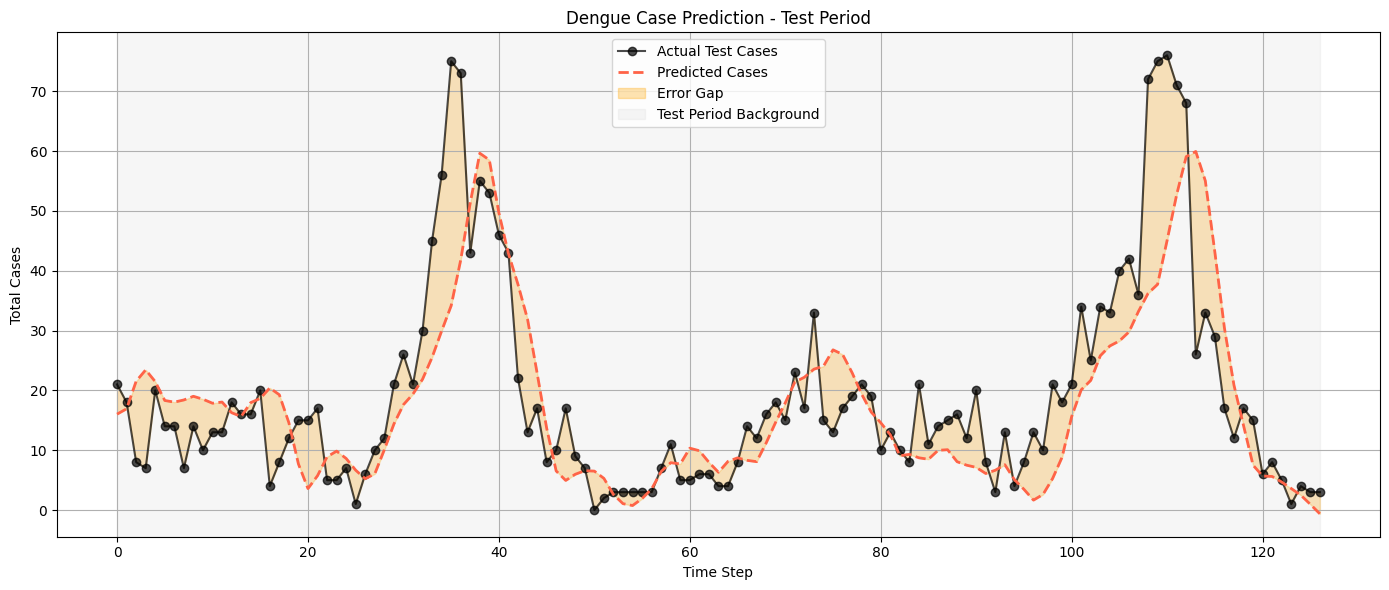

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Predict
pred_scaled = model.predict(X_test)
pred = target_scaler.inverse_transform(pred_scaled)
actual = target_scaler.inverse_transform(y_test)


# Evaluation
mse = mean_squared_error(actual, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

# Plotting with clear test/actual/predicted split
plt.figure(figsize=(14, 6))

# 1. Actual test cases
plt.plot(actual, 'o-', color='black', label='Actual Test Cases', alpha=0.7)

# 2. Model predictions
plt.plot(pred, '--', color='tomato', label='Predicted Cases', linewidth=2)

# 3. Fill between for visual error gap
plt.fill_between(range(len(actual)), actual.flatten(), pred.flatten(),
                 color='orange', alpha=0.3, label='Error Gap')

# 4. Highlight test area background
plt.axvspan(0, len(actual)-1, color='lightgray', alpha=0.2, label='Test Period Background')

# Labels and legend
plt.title("Dengue Case Prediction - Test Period")
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Test MSE: 119.03
Test RMSE: 10.91
Test MAE: 7.42


TypeError: 'int' object is not subscriptable

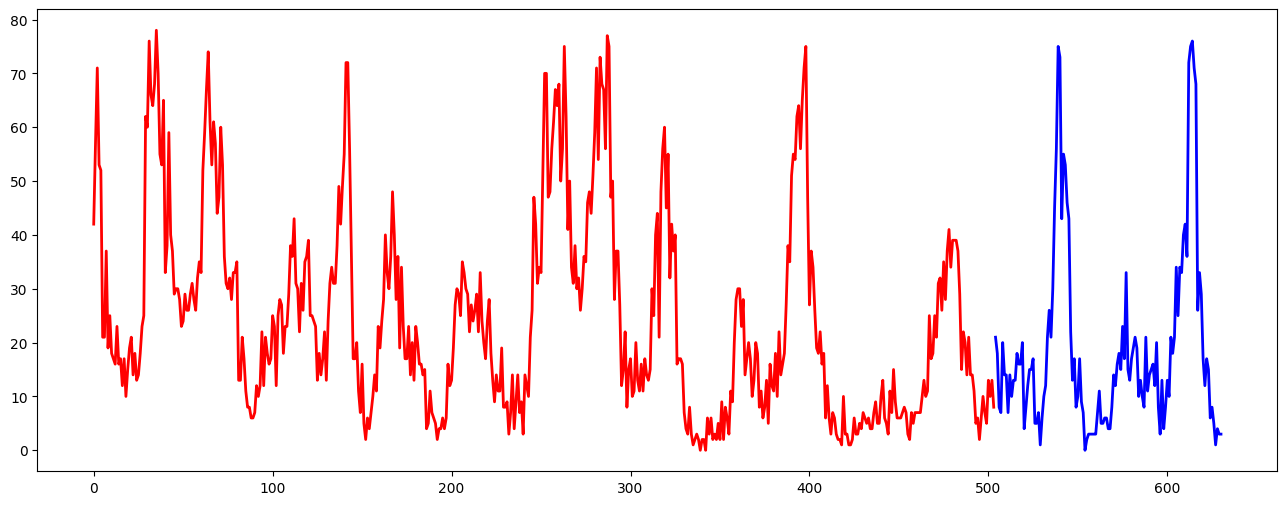

In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Predict and inverse transform
pred_scaled = model.predict(X_test)
pred = target_scaler.inverse_transform(pred_scaled)
actual_test = target_scaler.inverse_transform(y_test)
all_actual = target_scaler.inverse_transform(y)  # Full actual data

# Evaluation
mse = mean_squared_error(actual_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_test, pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

# Indices
test_start_idx = len(all_actual) - len(actual_test)
time_axis = np.arange(len(all_actual))

# Plot
plt.figure(figsize=(16, 6))

# Red line: full actual
plt.plot(time_axis[:test_start_idx], all_actual[:test_start_idx], label='Train Actual', color='red', linewidth=2)

# Blue line: test actual
plt.plot(time_axis[test_start_idx:], all_actual[test_start_idx:], label='Test Actual', color='blue', linewidth=2)

# Green line: prediction on test
plt.plot(time_axis[test_start_idx: ], pred, label='Predicted (Test)', color='green', linewidth=2)

# Final touches
plt.title("Dengue Total Cases Prediction (Train/Test Split)")
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Test MSE: 119.03
Test RMSE: 10.91
Test MAE: 7.42


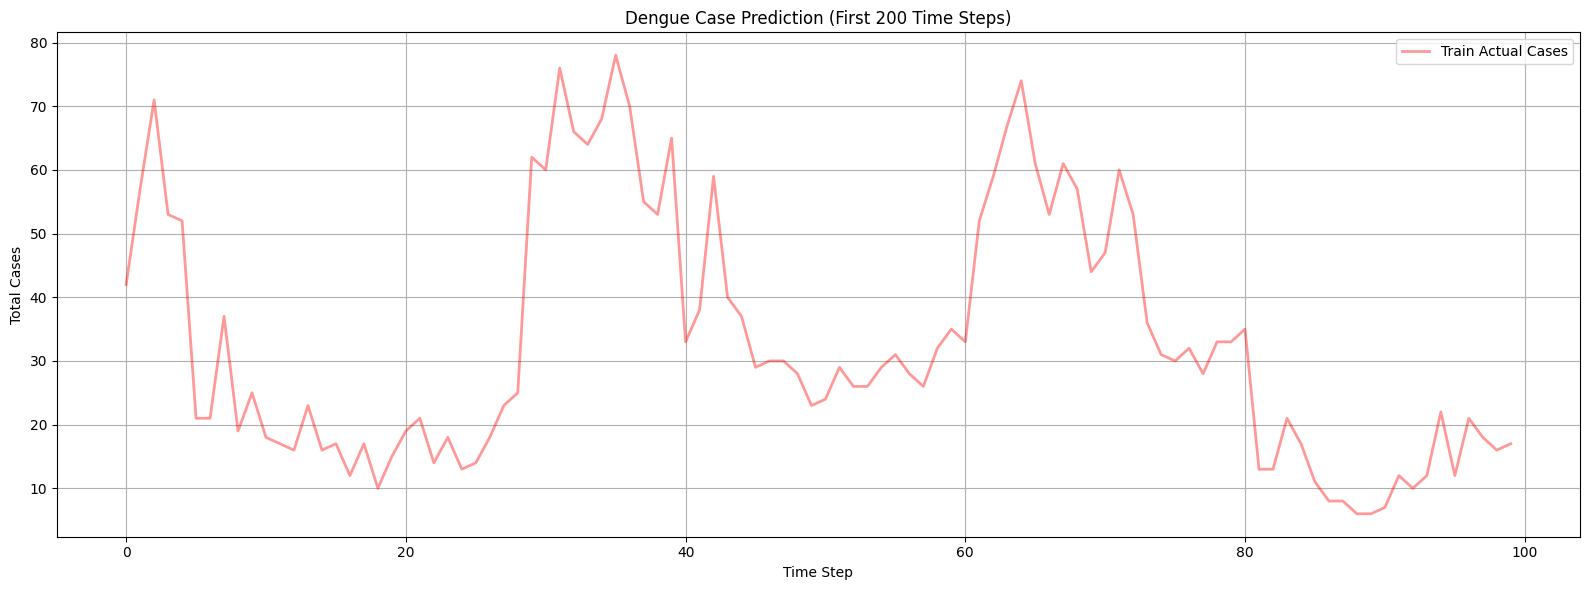

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Predict
pred_scaled = model.predict(X_test)
pred = target_scaler.inverse_transform(pred_scaled)
actual = target_scaler.inverse_transform(y_test)

# Concatenate all actual data (train + val + test)
all_actual = np.concatenate([target_scaler.inverse_transform(y_train),
                             target_scaler.inverse_transform(y_val),
                             actual])

# Evaluation
mse = mean_squared_error(actual, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

# Time axis and split point
total_len = len(all_actual)
test_start_idx = len(y_train) + len(y_val)
time_axis = np.arange(total_len)

# Limit to first 200 steps
max_steps = 100
time_axis = time_axis[:max_steps]
train_actual = all_actual[:test_start_idx][:max_steps]
test_actual = all_actual[test_start_idx:][:max_steps - test_start_idx] if max_steps > test_start_idx else []
predicted = pred[:max_steps - test_start_idx] if max_steps > test_start_idx else []

# Plot
plt.figure(figsize=(16, 6))

# 🔴 Train Actual
plt.plot(time_axis[:len(train_actual)], train_actual,
         label='Train Actual Cases', color='red', linewidth=2, alpha=0.4)

# 🔵 Test Actual
if len(test_actual) > 0:
    plt.plot(time_axis[len(train_actual):len(train_actual) + len(test_actual)], test_actual,
             label='Test Actual Cases', color='blue', linewidth=2)

# 🟢 Predicted
if len(predicted) > 0:
    plt.plot(time_axis[len(train_actual):len(train_actual) + len(predicted)], predicted,
             label='Predicted Cases', color='green', linewidth=2, linestyle='--')

plt.title("Dengue Case Prediction (First 200 Time Steps)")
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [81]:
# Forecasting next 100 time steps (future prediction)
future_steps = 100
future_predictions = []

# Start with last window from full data
last_window = X_feat[-window_size:].copy()
window = last_window.reshape(1, window_size, X_feat.shape[1])

for _ in range(future_steps):
    # Predict next value
    next_scaled = model.predict(window, verbose=0)
    
    # Save prediction
    future_predictions.append(next_scaled[0][0])
    
    # Create next window by appending the prediction and dropping the first time step
    # Replace the 'total_cases_lag' features with predicted values
    next_input = window[0, -1, :].copy()
    # Shift lags
    if 'total_cases_lag3' in features.columns:
        idx_lag1 = features.columns.get_loc('total_cases_lag1')
        idx_lag2 = features.columns.get_loc('total_cases_lag2')
        idx_lag3 = features.columns.get_loc('total_cases_lag3')
        # Shift lags in the input
        next_input[idx_lag3] = next_input[idx_lag2]
        next_input[idx_lag2] = next_input[idx_lag1]
        next_input[idx_lag1] = next_scaled[0][0]
    else:
        pass  # if no lag features, skip
    
    # Append to window
    window = np.append(window[:, 1:, :], [[next_input]], axis=1)

# Inverse transform predictions
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_cases = target_scaler.inverse_transform(future_predictions)


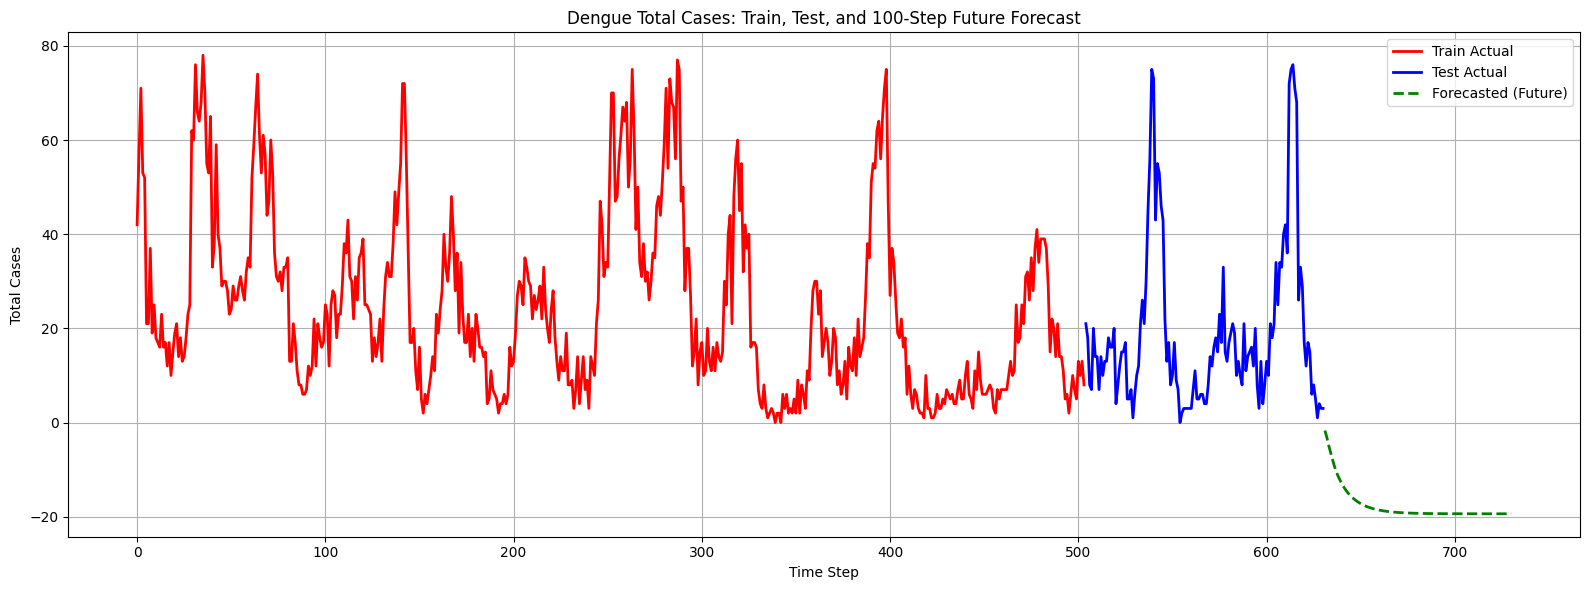

In [82]:
plt.figure(figsize=(16, 6))

# Time ranges
train_len = len(all_actual) - len(actual_test)
future_start = len(all_actual)
future_end = future_start + future_steps

# Red = Train, Blue = Test, Green = Future
plt.plot(np.arange(train_len), all_actual[:train_len], color='red', label='Train Actual', linewidth=2)
plt.plot(np.arange(train_len, future_start), all_actual[train_len:], color='blue', label='Test Actual', linewidth=2)
plt.plot(np.arange(future_start, future_end), future_cases, color='green', linestyle='--', label='Forecasted (Future)', linewidth=2)

plt.title("Dengue Total Cases: Train, Test, and 100-Step Future Forecast")
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
